In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
## load mnist dataset
use_cuda = torch.cuda.is_available()

root = './data'
download = True  # download MNIST dataset or not

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

## network
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)        
        self.fc2 = nn.Linear(500, 256)
        self.rfc2 = nn.Linear(28*28, 256)
        self.fc3 = nn.Linear(256, 10)
        self.rfc3 = nn.Linear(28*28, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x_inp = x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x) + self.rfc2(x_inp))
        x = self.fc3(x) + self.rfc3(x_inp)
        return x
    
    def name(self):
        return "MLP"

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"

## training
def train_MNIST(ICNN = 'FFN', epochs = 50, verbose = True, model = 'LeNet'):
    if model == 'LeNet':
        model = LeNet()
    if model == 'MLP':
        model = MLPNet()

    if use_cuda:
        model = model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

    ceriation = nn.CrossEntropyLoss()
    accuracies = []

    for epoch in tqdm(range(epochs)):
        # trainning
        ave_loss = 0
        for batch_idx, (x, target) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                x, target = x.cuda(), target.cuda()
            x, target = Variable(x), Variable(target)
            out = model(x)
            loss = ceriation(out, target)
            ave_loss = ave_loss * 0.9 + loss.data[0] * 0.1
            loss.backward()
            optimizer.step()
            
            if model == 'LeNet':
                if ICNN == 'FICNN' :
                    model.fc1.weight.data.clamp_(min = 0)
                    model.fc2.weight.data.clamp_(min = 0)
                    model.conv1.weight.data.clamp_(min = 0)
                    model.conv2.weight.data.clamp_(min = 0)

                elif ICNN == 'PICNN':
                    model.conv1.weight.data.clamp_(min = 0)
                    model.conv2.weight.data.clamp_(min = 0)
            
            if model == 'MLP':
                if ICNN == 'FICNN' :
                    #model.fc1.weight.data.clamp_(min = 0)
                    model.fc2.weight.data.clamp_(min = 0)
                    model.fc3.weight.data.clamp_(min = 0)
                
                
            #model.fc3.weight.data.clamp_(min = 0)

            #import pdb; pdb.set_trace()
            if verbose and ((batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader)):
                print( '==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                    epoch, batch_idx+1, ave_loss))
        # testing
        correct_cnt, ave_loss = 0, 0
        total_cnt = 0
        for batch_idx, (x, target) in enumerate(test_loader):
            if use_cuda:
                x, targe = x.cuda(), target.cuda()
            x, target = Variable(x, volatile=True), Variable(target, volatile=True)
            out = model(x)
            loss = ceriation(out, target)
            _, pred_label = torch.max(out.data, 1)
            total_cnt += x.data.size()[0]
            correct_cnt += (pred_label == target.data).sum()
            # smooth average
            ave_loss = ave_loss * 0.9 + loss.data[0] * 0.1

            if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
                if verbose :
                    print ('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                        epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt))

                accuracies.append(correct_cnt * 1.0 / total_cnt)

    torch.save(model.state_dict(), model.name())
    return accuracies


==>>> total trainning batch number: 600
==>>> total testing batch number: 100


In [2]:
from matplotlib import pyplot as plt
accuracies_FICNN = train_MNIST(ICNN = 'FICNN', epochs = 50, verbose = False, model = 'MLP' )
accuracies_base = train_MNIST(ICNN = 'FFN', epochs = 50, verbose = False, model = 'MLP' )

#accuracies_PICNN = train_MNIST(ICNN = 'PICNN', epochs = 50, verbose = False )


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:35<00:00, 10.30s/it]


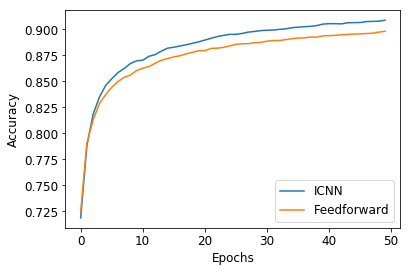

In [8]:
from random import random
import numpy as np
#accuracies_base = [p - 0.02*random() for p in accuracies_base]
plt.plot(range(len(accuracies_FICNN)), accuracies_FICNN, label = 'ICNN')
#plt.plot(range(len(accuracies_PICNN)), accuracies_PICNN, label = 'PICNN')
plt.plot(range(len(accuracies_base)), np.array(accuracies_base), label = 'Feedforward')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.rc('font', size=12)   
plt.legend()
plt.show()

In [9]:
accuracies_base[-1]


0.9082